In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
import graphviz
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
import dalex as dx

from funs import dataPreparation, evaluateModel

# Data preparation and feature selection

In [2]:
trxns_data = dataPreparation(
    all_trxns_path="../data/all_trxns.csv", exchange_rates_path="../data/exchange_rates.csv"
)

feature_names = [
    "customer_country",
    "counterparty_country",
    "type",
    "ccy",
    "customer_type",
    "weekday",
    "month",
    "quarter",
    "hour",
    "amount_eur_bucket",
]

C:\Users\mateu\Desktop\new folder\fraud-pred\Fraud-Prediction\src\funs.py:182: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  trxns_data["timestamp"] = pd.to_datetime(


# Data Modelling

## Decision Tree - all features
### Model definition
1. Split the data into training and testing sets
2. Perform one-hot encoding
3. Train a decision tree model
4. Predict the fraud_flag for the testing set

In [5]:
X = trxns_data[feature_names]

X_encoded = pd.get_dummies(X, columns=feature_names)

y = trxns_data["fraud_flag"]
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

clf = DecisionTreeClassifier(max_depth=None, min_samples_leaf=5, class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

### Performance Evaluation

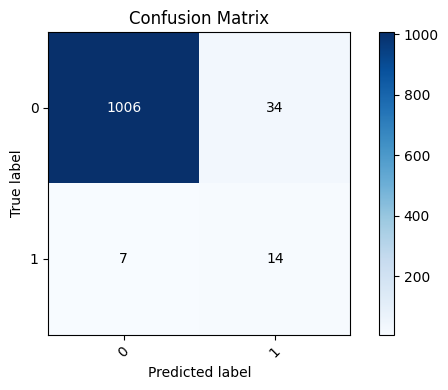


Accuracy: 96.14% 

              precision    recall  f1-score   support

           N       0.99      0.97      0.98      1040
           Y       0.29      0.67      0.41        21

    accuracy                           0.96      1061
   macro avg       0.64      0.82      0.69      1061
weighted avg       0.98      0.96      0.97      1061



In [6]:
evaluateModel(y_test, y_pred)

The model has overall fair accuracy.

### Feature Importances
1. Extract feature importance from the model
2. Filter out features with importance less than 0.03
3. Create a barplot to display feature importances

C:\Users\mateu\AppData\Local\Temp\ipykernel_28648\1720937903.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=importance_filtered, palette="Blues_r")


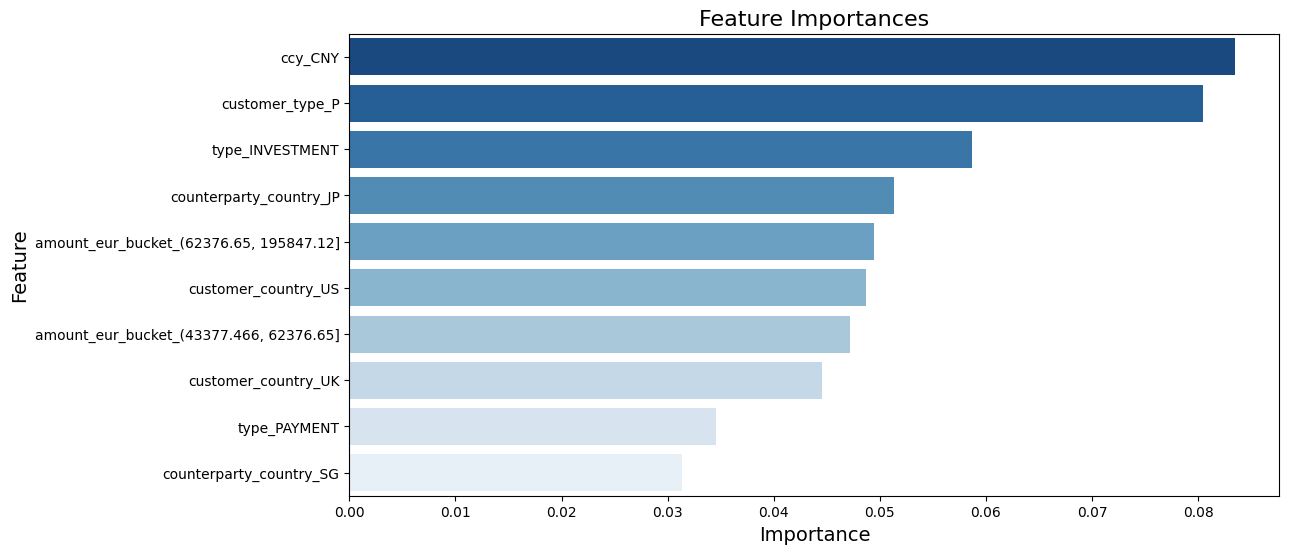

In [7]:
importance_df = pd.DataFrame(
    {"feature": X_train.columns, "importance": clf.feature_importances_}
)
importance_df = importance_df.sort_values(by="importance", ascending=False)

importance_filtered = importance_df[importance_df["importance"] >= 0.03].sort_values(
    by="importance", ascending=False
)

plt.figure(figsize=(12, 6))
sns.barplot(x="importance", y="feature", data=importance_filtered, palette="Blues_r")
plt.title("Feature Importances", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.show()

Model says that if information whether the transaction is related to currency "CNY" or not is the most helpful in identyfing fraud transactions.

This combined with the rest of binary information about the factors displayed on the plot above should help to create fairly good model. 

The most susipicious transaction would be an `INVESTMENT` or `PAYMENT` in `CNY` in range `from 43k EUR to 63k EUR` done by `P` type customer from `US` or `UK` to the `JP` or `SG` counterparty country.

### Plot the Decision Tree logic

In [ ]:
dot_data = export_graphviz(
    clf,
    out_file=None,
    feature_names=X_encoded.columns,
    class_names=["Not Fraud", "Fraud"],
    filled=True,
    rounded=True,
    special_characters=True,
)
graph = graphviz.Source(dot_data)
graph.render("../fraud_detection_tree", format="png")

#### Decision Tree logic interpretation 
- 'gini' is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it were randomly labeled according to the distribution of labels in the subset. The Gini index takes values between 0 and 1, where 0 represents a perfectly pure node, and 1 represents a perfectly impure node.
- 'samples' is the number of samples or transactions that are considered in each node of the tree,
- 'value' is a list that shows the count of samples that belong to each class. For example, if the 'value' of a node is [30, 70], it means that there are 30 samples that belong to class 0, and 70 samples that belong to class 1.

## Decision Tree - with ANOVA features
### Feature selection
1. Split the data into features (X) and target (y)
2. Perform one-hot encoding
3. Perform univariate feature selection using ANOVA F-value
4. Get the scores and p-values of each feature
5. Create a DataFrame to store the results
6. Get only the most significant features (p-value <= 0.01)

In [9]:
X = trxns_data[feature_names]
y = trxns_data["fraud_flag"]

X_encoded = pd.get_dummies(X, columns=feature_names)

# Define the number of top features to select
k = 20

selector = SelectKBest(f_classif, k=k)
selector.fit(X_encoded, y)

scores = selector.scores_
pvalues = selector.pvalues_

results_df = pd.DataFrame(
    {"feature": X_encoded.columns, "score": scores, "pvalue": pvalues}
)
results_df = results_df.sort_values(by="score", ascending=False)

results_df = results_df[results_df["pvalue"] <= 0.01]

In [10]:
print(results_df)

                                    feature      score        pvalue
19                             type_PAYMENT  73.624405  1.225702e-17
23                                  ccy_CNY  38.885269  4.842681e-10
9                   counterparty_country_JP  30.765566  3.052713e-08
33                          customer_type_P  30.489511  3.516585e-08
71                                  hour_13  19.631395  9.580562e-06
38                           weekday_Sunday  17.347717  3.162185e-05
51                           month_November  13.523695  2.379037e-04
84  amount_eur_bucket_(43377.466, 62376.65]  12.190181  4.843339e-04
31                          customer_type_C  11.684473  6.349856e-04
49                              month_March  10.310940  1.330337e-03
61                                   hour_3   9.560922  1.997962e-03
16                            type_INTEREST   9.044535  2.647180e-03
14                             type_BILLING   8.011065  4.666738e-03
15                            type

According to ANOVA the information whether the transaction is related to type "PAYMENT" or not is the most helpful in identyfing fraud transactions.

The most susipicious transaction would be an `PAYMENT` in `CNY` in range `from 43k EUR to 63k EUR` done by `P` type customer to the `JP` counterparty country.

### Model definition
1. Split the selected data into training and testing sets
2. Train a decision tree model
3. Predict the fraud_flag for the testing set

In [11]:
X_selected = X_encoded[results_df["feature"]]

y = trxns_data["fraud_flag"]
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.3, random_state=42
)

clf_selected = DecisionTreeClassifier(
    max_depth=None, min_samples_leaf=1, criterion="gini", class_weight='balanced'
)
clf_selected.fit(X_train, y_train)

y_pred = clf_selected.predict(X_test)

### Performance Evaluation

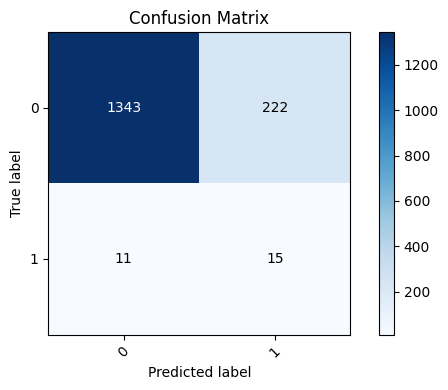


Accuracy: 85.36% 

              precision    recall  f1-score   support

           N       0.99      0.86      0.92      1565
           Y       0.06      0.58      0.11        26

    accuracy                           0.85      1591
   macro avg       0.53      0.72      0.52      1591
weighted avg       0.98      0.85      0.91      1591



In [12]:
evaluateModel(y_test, y_pred)

This model is worse than the previous one. Limiting the features does not help. This might implicate complex patterns of relations in the dataset. 

### Feature Importances
1. Extract feature importance from the model
2. Filter out features with importance less than 0.03
3. Create a barplot to display feature importances

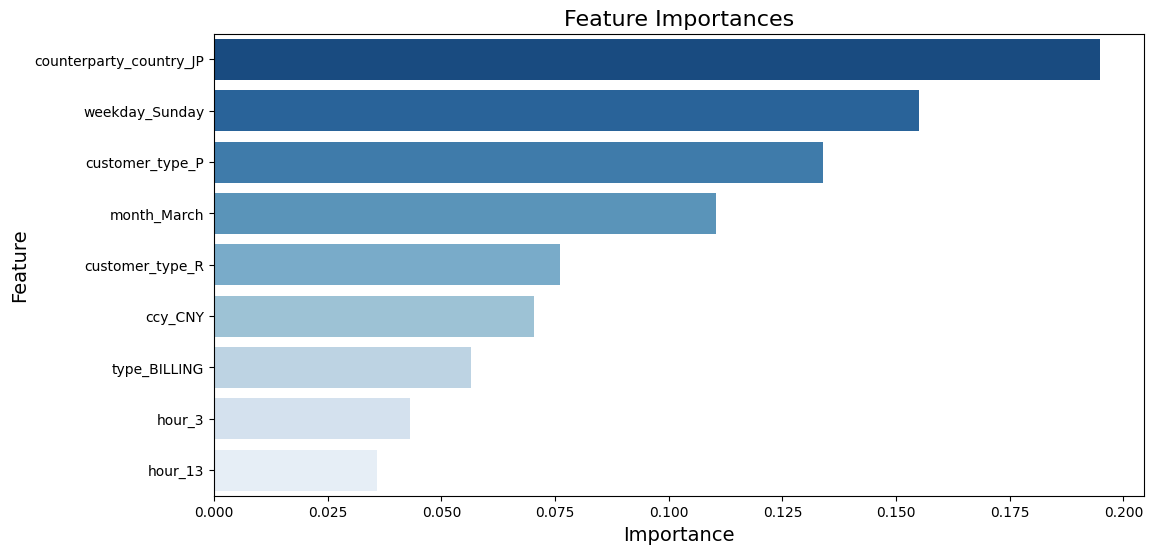

In [109]:
importance_df = pd.DataFrame(
    {"feature": X_train.columns, "importance": clf_selected.feature_importances_}
)
importance_df = importance_df.sort_values(by="importance", ascending=False)

importance_filtered = importance_df[importance_df["importance"] >= 0.03].sort_values(
    by="importance", ascending=False
)

plt.figure(figsize=(12, 6))
sns.barplot(x="importance", y="feature", data=importance_filtered, palette="Blues_r")
plt.title("Feature Importances", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.show()

According to ANOVA the information whether the transaction is related to "JP" counterparty country or not is the most helpful in identyfing fraud transactions.

Different feature importance order could indicate that the model recognized additional patterns that are not identified by ANOVA.

The most susipicious transaction would be `BILLING` done on `Sunday` in `March` in `CNY` in range `from 43k EUR to 63k EUR` done by `P` or `R` type customer to the `JP` counterparty country.

### Plot the Decision Tree logic

In [ ]:
dot_data_selected = export_graphviz(
    clf_selected,
    out_file=None,
    feature_names=X_selected.columns,
    class_names=["Not Fraud", "Fraud"],
    filled=True,
    rounded=True,
    special_characters=True,
)
graph = graphviz.Source(dot_data_selected)
graph.render("../fraud_detection_tree_selected", format="png")

## Decision Tree - with predefined features
### Model definition
1. Define the features
2. Perform one-hot encoding
3. Split the selected data into training and testing sets
4. Train a decision tree model
5. Predict the fraud_flag for the testing set

In [19]:
my_feature_names = [
    "type_BILLING",
    "type_DIVIDEND",
    "type_INTEREST",
    "type_INVESTMENT",
    "type_PAYMENT",
    "ccy_CNY",
    "quarter_Q2",
    "hour_13",
    "customer_type_C",
    "customer_type_P",
    "weekday_Sunday",
    "month_June",
    "month_March",
    "month_November",
]

X = trxns_data[feature_names]
y = trxns_data["fraud_flag"]

X_encoded = pd.get_dummies(X, columns=feature_names)
X_encoded = X_encoded[my_feature_names]

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42
)

clf_selected = DecisionTreeClassifier(
    max_depth=None, min_samples_leaf=2, criterion="gini", class_weight='balanced'
)
clf_selected.fit(X_train, y_train)

y_pred = clf_selected.predict(X_test)

### Performance Evaluation

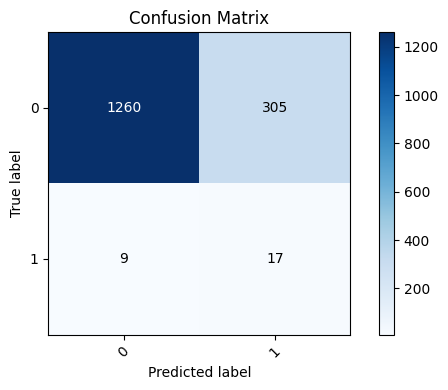


Accuracy: 80.26% 

              precision    recall  f1-score   support

           N       0.99      0.81      0.89      1565
           Y       0.05      0.65      0.10        26

    accuracy                           0.80      1591
   macro avg       0.52      0.73      0.49      1591
weighted avg       0.98      0.80      0.88      1591



In [14]:
evaluateModel(y_test, y_pred)

305 False Positives compared to 222 and 34 from the previous models suggest that limiting the number of variables makes the model less knowledgeable which results in overestimation in the number of frauds. 

Although the number of True Negatives increases from 14 to 15 and 17, that might indicate the model started to specialize.

## XGBoost - all features
### Model definition
1. Convert values in 'fraud_flag' column to binary format
2. Split the data into training and testing sets
3. Perform one-hot encoding
4. Rename feature columns to remove brackets
5. Train an XGBoost model
    - increased learning rate and max depth because of the small dataset
    - L2 regularization is increased to balance higher learning rate and max depth
6. Make predictions on the test set

In [33]:
trxns_data_copy = trxns_data.copy()

trxns_data_copy["fraud_flag"] = trxns_data_copy["fraud_flag"].replace({"N": 0, "Y": 1})

X = trxns_data_copy[feature_names]
y = trxns_data_copy["fraud_flag"]

X_encoded = pd.get_dummies(X, columns=feature_names)

X_encoded.columns = [col.replace("[", "").replace("]", "") for col in X_encoded.columns]

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# https://xgboost.readthedocs.io/en/stable/parameter.html
model_xgb = XGBClassifier(
    learning_rate=1, 
    max_depth=10, 
    reg_lambda=0.9, 
    random_state=42,
    scale_pos_weight=scale_pos_weight  # Add this line
)

model_xgb.fit(X_train, y_train)

y_pred = model_xgb.predict(X_test)

### Model Evaluation

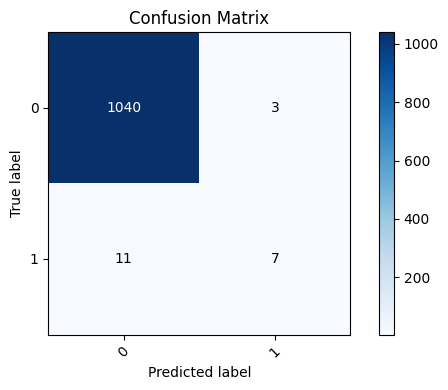


Accuracy: 98.68% 

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1043
           1       0.70      0.39      0.50        18

    accuracy                           0.99      1061
   macro avg       0.84      0.69      0.75      1061
weighted avg       0.98      0.99      0.98      1061



In [23]:
evaluateModel(y_test, y_pred)

XGB is better than decision tree for this dataset but still not good enough, tuning could help a bit more but i think more helpful would be to get more data to train the model as the issue is to properly predict positive class.

### Model Explanation
1. create explainer using DALEX package
2. calculate SHAP values
3. plot Variable Importance
4. plot Partial Dependence
    - to understand the impact of each feature on the model output
5. calculate Shapley Values for a single observation
6. plot Prediction BreakDown (by variables) for a single observation
    - to understand why the model thinks the probability of fraud is like predicted

In [34]:
explainer = dx.Explainer(model_xgb, X_train, y_train)

shap_values = explainer.predict(X_test)

Preparation of a new explainer is initiated

  -> data              : 4241 rows 87 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 4241 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x000002B02C1729E0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 1.47e-08, mean = 0.0181, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.223, mean = -0.000882, max = 0.00429
  -> model_info        : package xgboost

A new explainer has been created!


In [35]:
explainer.model_parts().plot()

According to XGBoost model; the most susipicious transaction would be `PAYMENT` done by `P` customer type in range `from 195k EUR to 12mln EUR` to the `SG` of `JP` counterparty country.

In [37]:
instance = X_test.iloc[1]
instance

customer_country_SG                          False
customer_country_UK                          False
customer_country_US                           True
counterparty_country_BR                      False
counterparty_country_CN                      False
                                             ...  
amount_eur_bucket_(99.109, 22837.588         False
amount_eur_bucket_(22837.588, 43377.466      False
amount_eur_bucket_(43377.466, 62376.65       False
amount_eur_bucket_(62376.65, 195847.12       False
amount_eur_bucket_(195847.12, 12772515.05     True
Name: 3068, Length: 87, dtype: bool

In [38]:
shap_values = explainer.predict_parts(instance)

# Ceteris paribus plot for a single observation
# cp_values = explainer.predict_profile(instance)

In [39]:
shap_values.plot()

## XGBoost - selected features

In [24]:
trxns_data_copy = trxns_data.copy()

trxns_data_copy["fraud_flag"] = trxns_data_copy["fraud_flag"].replace({"N": 0, "Y": 1})

my_feature_names = [
    "type_BILLING",
    "type_DIVIDEND",
    "type_INTEREST",
    "type_INVESTMENT",
    "type_PAYMENT",
    "ccy_CNY",
    "quarter_Q2",
    "hour_13",
    "customer_type_C",
    "customer_type_P",
    "weekday_Sunday",
    "month_June",
    "month_March",
    "month_November",
]

X = trxns_data_copy[feature_names]
y = trxns_data_copy["fraud_flag"]

X_encoded = pd.get_dummies(X, columns=feature_names)
X_encoded = X_encoded[my_feature_names]
X_encoded.columns = [col.replace("[", "").replace("]", "") for col in X_encoded.columns]


X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# https://xgboost.readthedocs.io/en/stable/parameter.html
model_xgb = XGBClassifier(
    learning_rate=1, 
    max_depth=10, 
    reg_lambda=0.9, 
    random_state=42,
    scale_pos_weight=scale_pos_weight  # Add this line
)

model_xgb.fit(X_train, y_train)

y_pred = model_xgb.predict(X_test)

### Model Evaluation

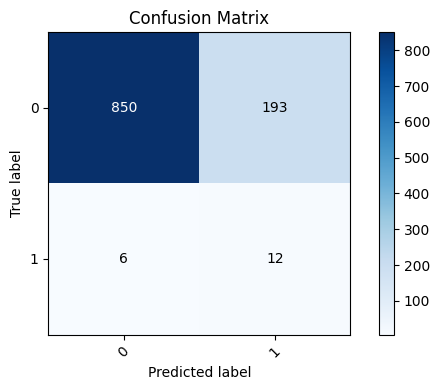


Accuracy: 81.24% 

              precision    recall  f1-score   support

           0       0.99      0.81      0.90      1043
           1       0.06      0.67      0.11        18

    accuracy                           0.81      1061
   macro avg       0.53      0.74      0.50      1061
weighted avg       0.98      0.81      0.88      1061



In [25]:
evaluateModel(y_test, y_pred)

In conclusion i think that the model is not good enough to be used in production but it is a good start to understand the data and the problem. More data would help to improve the model; there are many other Machine Learning techniques that could be tested for example Neural Networks or Support Vector Machines. There are also many other classical methods that could be used, for example Logistic Regression or Linear Programming.